# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [1]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [18, 9]

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [2]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return ((np.linalg.norm(np.dot(X, w)-y))**2)/X.shape[0]

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2*((np.dot(X.transpose(), (np.dot(X, w)-y))))/X.shape[0]

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    w_init = w_init.copy()
    result = [w_init.copy()]
    for _ in range(n_iterations):
        w_init -= lr*loss.calc_grad(X, y, w_init)
        result.append(w_init.copy())
    return result

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.5891768045025
0.8670644395649494


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

**Вывод**: При уменьшении длины шага наблюдаются меньшие "скачки" при градентном спуске. Однако, при малых размерах шага спуск останавливается, не достигнув минимума ошибки (было взято 300 шагов спуска, чтобы показать данную зависимость).

Learning rate: 0.01


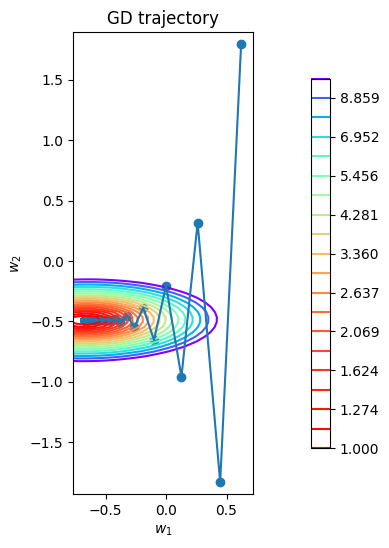

Learning rate: 0.0025


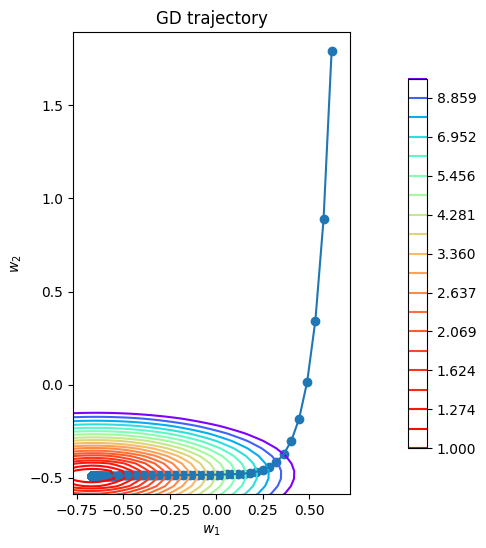

Learning rate: 0.000625


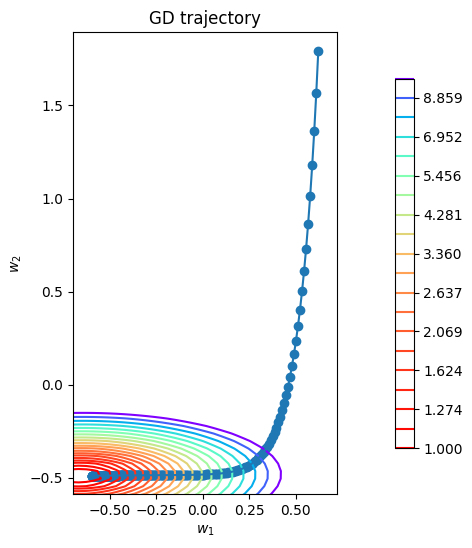

Learning rate: 0.00015625


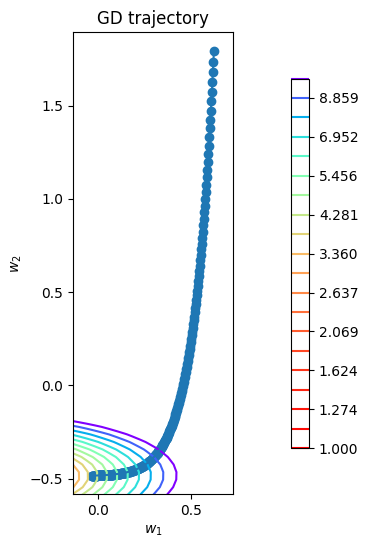

In [9]:

lr = 0.01
while lr >= 0.0001:
    print(f"Learning rate: {lr}")
    plot_gd(gradient_descent(w_init, X, y, loss, lr, 300), X, y, loss)
    lr /= 4

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    w_init = w_init.copy()
    result = [w_init.copy()]
    for _ in range(n_iterations):
        indexes = np.random.choice(X.shape[0], batch_size)
        w_init -= lr*loss.calc_grad(X.take(indexes, axis=0),
                                    y.take(indexes, axis=0), w_init)
        result.append(w_init.copy())
    return result

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

**Вывод**: При уменьшении длины шага наблюдаются  меньшие "скачки" при градентном спуске. Однако, при малых размерах шага спуск останавливается, не достигнув минимума ошибки (было взято 100 шагов спуска, чтобы показать данную зависимость). Причем аплитуда "скачков" увеличивается при уменьшении размера батча. Иногда, при уменьшении ошибки на подвыборке, общая ошибка увеличивается (явно видно на графиках с маленьким размеров батча).

Batch size:100
Learning rate: 0.01


<Figure size 1800x900 with 0 Axes>

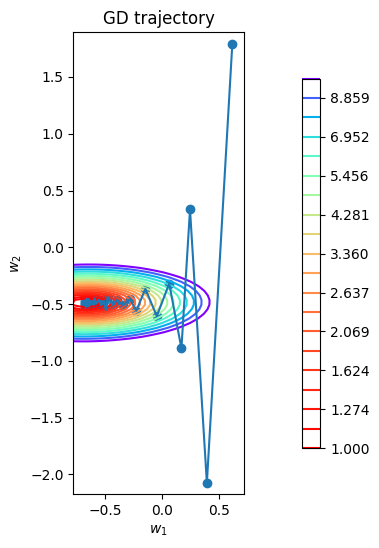

Batch size:33
Learning rate: 0.01


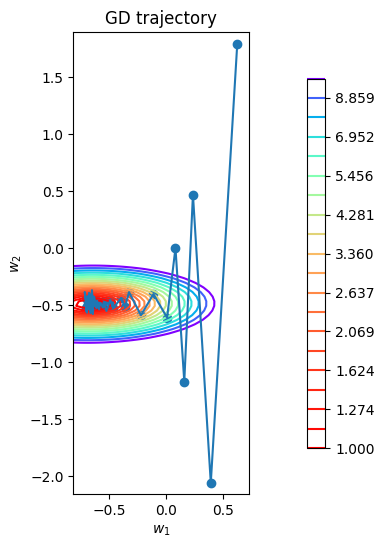

Batch size:11
Learning rate: 0.01


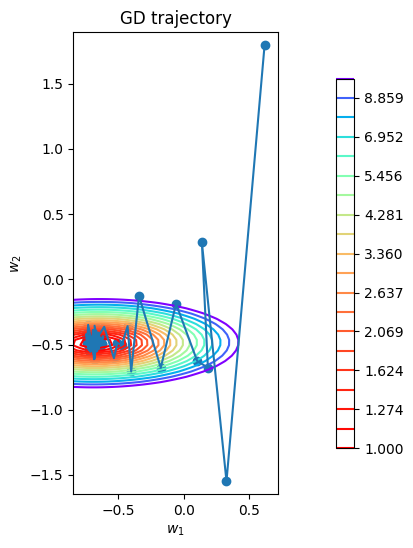

Batch size:3
Learning rate: 0.01


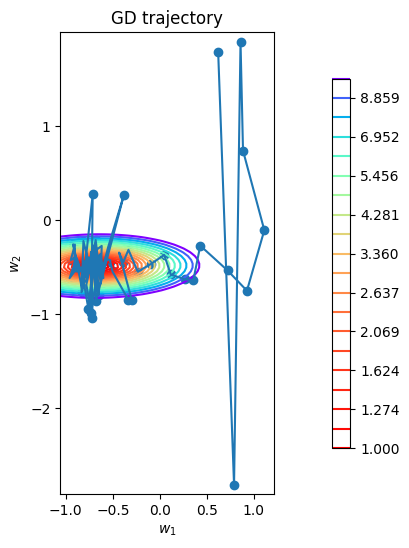

Batch size:100
Learning rate: 0.0025


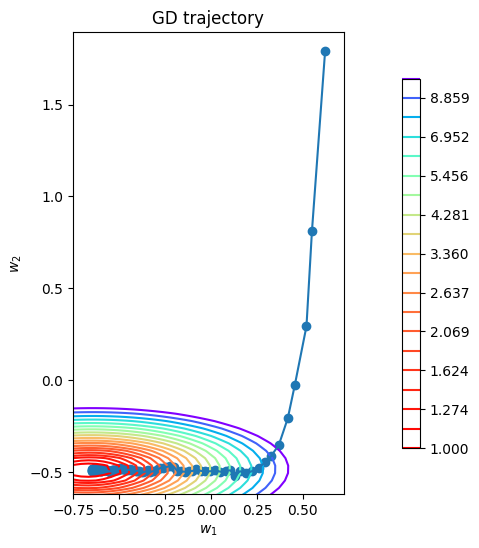

Batch size:33
Learning rate: 0.0025


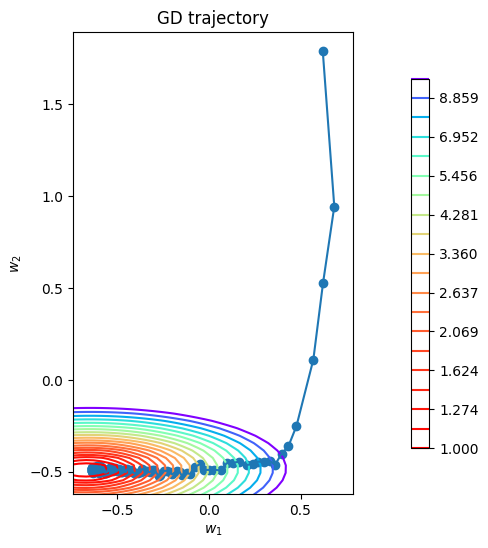

Batch size:11
Learning rate: 0.0025


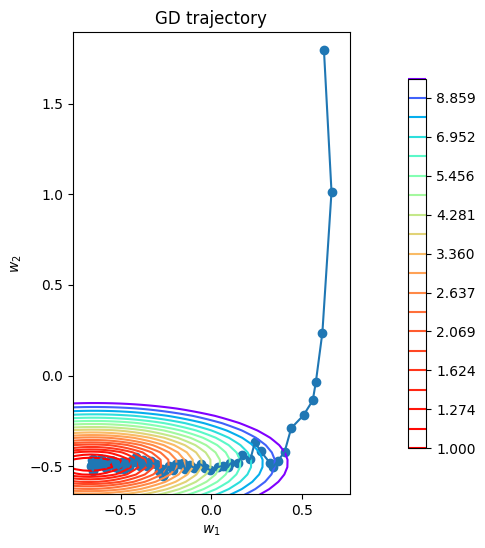

Batch size:3
Learning rate: 0.0025


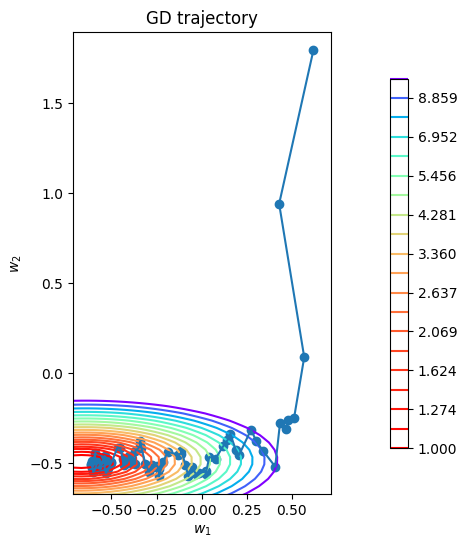

Batch size:100
Learning rate: 0.000625


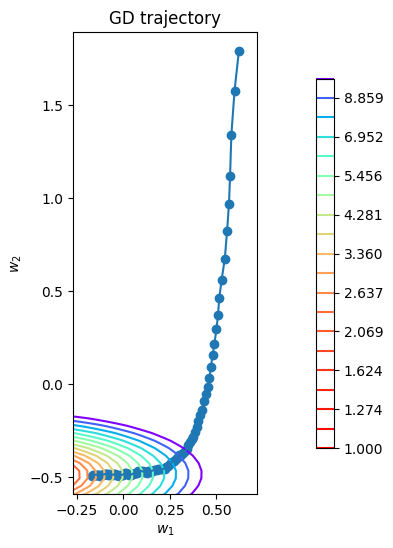

Batch size:33
Learning rate: 0.000625


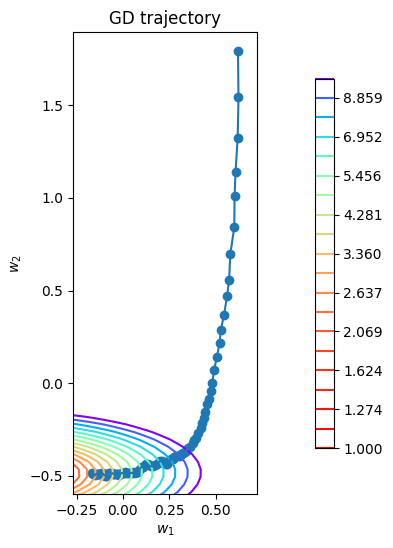

Batch size:11
Learning rate: 0.000625


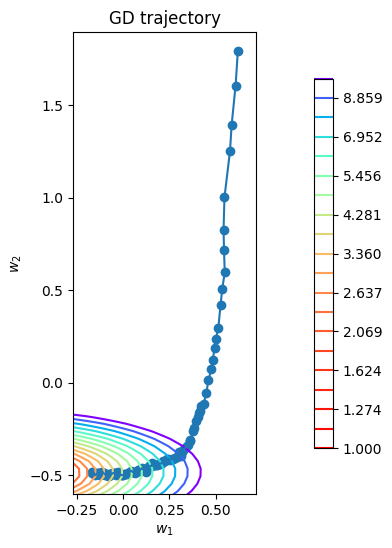

Batch size:3
Learning rate: 0.000625


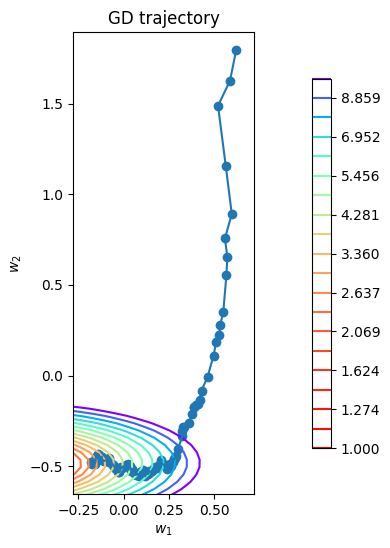

Batch size:100
Learning rate: 0.00015625


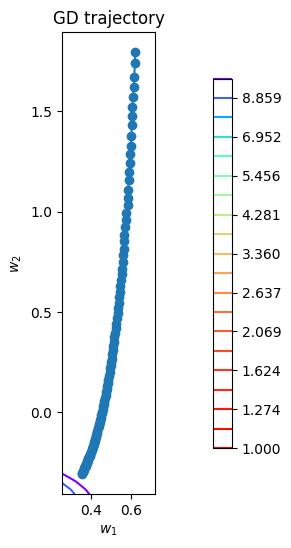

Batch size:33
Learning rate: 0.00015625


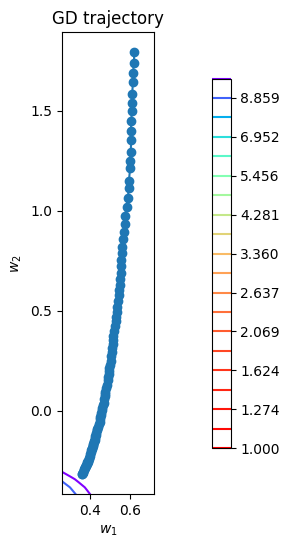

Batch size:11
Learning rate: 0.00015625


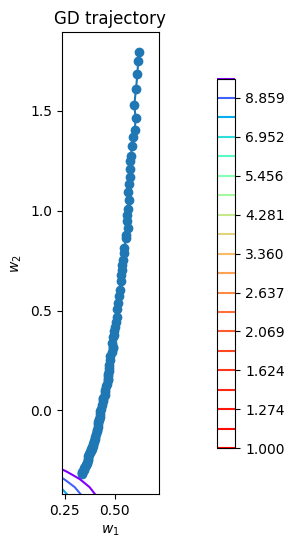

Batch size:3
Learning rate: 0.00015625


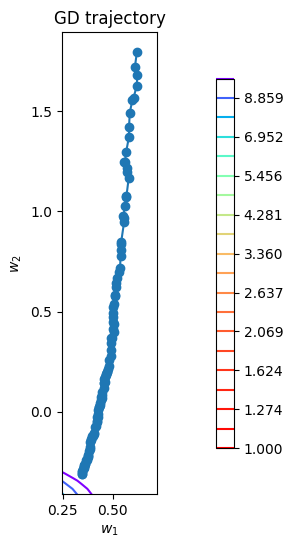

In [11]:
lr = 0.01
fig = plt.figure()
while lr >= 0.0001:
    batch_size = 100
    while batch_size > 1:
        print(f"Batch size:{batch_size}\nLearning rate: {lr}")
        plot_gd(stochastic_gradient_descent(
            w_init, X, y, loss, lr, batch_size, 100), X, y, loss)
        batch_size //= 3
    lr /= 4

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    l_0 = lr
    w_init = w_init.copy()
    result = [w_init.copy()]
    for i in range(n_iterations):
        lr = l_0*((1/(1+i))**p)
        indexes = np.random.choice(X.shape[0], batch_size)
        w_init -= lr*loss.calc_grad(X.take(indexes, axis=0),
                                    y.take(indexes, axis=0), w_init)
        result.append(w_init.copy())
        
    return result

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

**Вывод**: При увеличении p, скорость градиентного спуска уменьшаяется, так как функция f(p)=e^p убывается на интервале [0; 1]. При больших начениях p градиент не доходит до точки минимума, но амплитуда "скачков" уменьшается.

P: 1


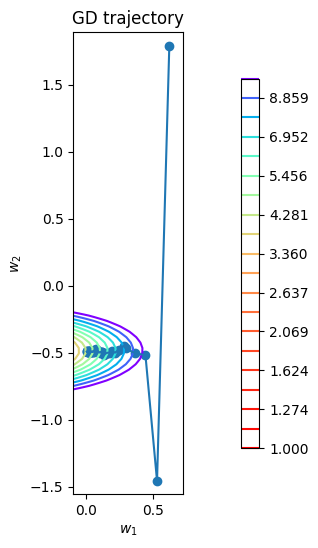

P: 0.5


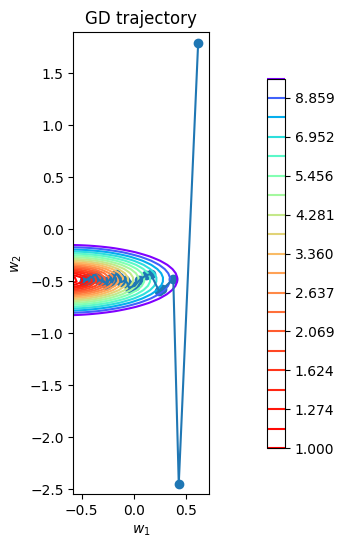

P: 0.25


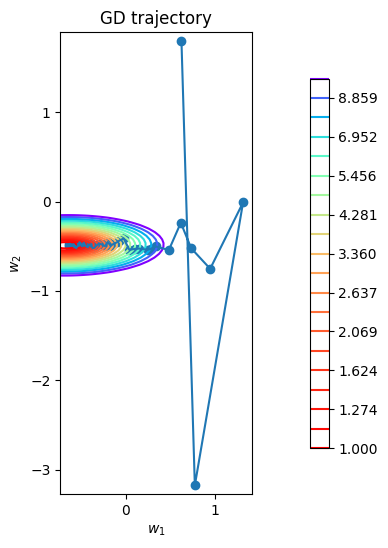

P: 0.125


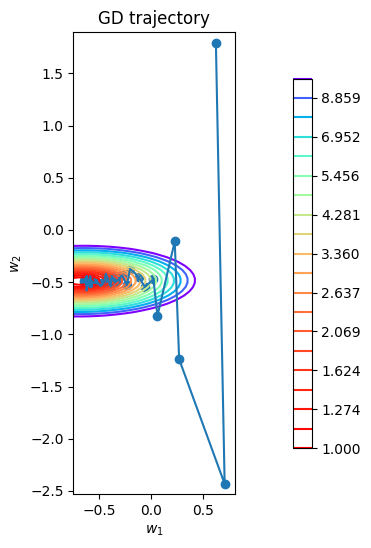

In [13]:
lr = 0.01
batch_size = 10
p = 1
while p > 0.1:
    print(f"P: {p}")
    plot_gd(stochastic_gradient_descent(
            w_init, X, y, loss, lr, batch_size, p, 50), X, y, loss)
    p /= 2

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

**Вывод**: На данном графике не наблюдается явного преимущество ни у одного из способов спуска, это может происходить из-за достаточно маленького количества признаков (2) по сравнению с размером батча (10), а также "хороших" исходных данных. Однако, стоит заметить, что стохастический спуск будет выполняться гораздо быстрее (из-за маленького размера батча).

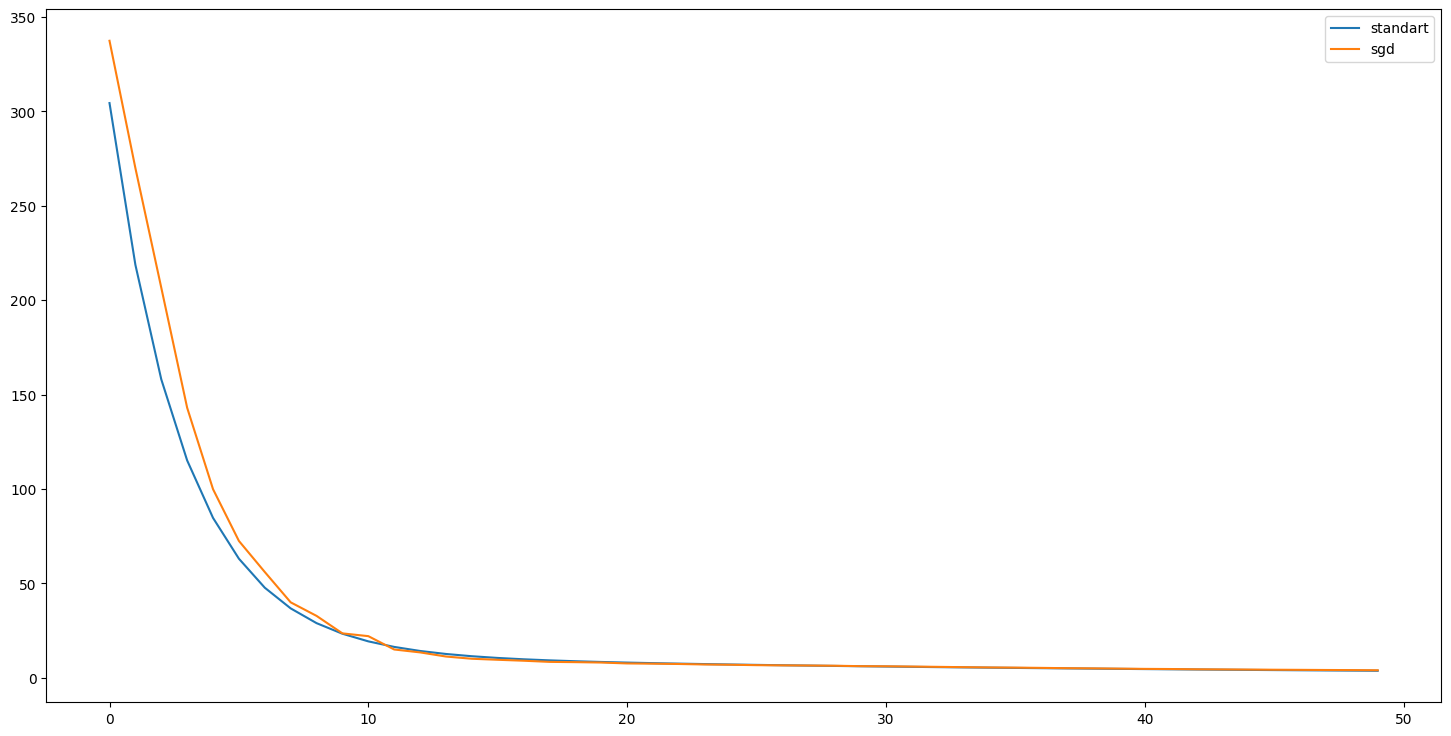

In [14]:
lr = 0.001
rep = 50
standart = gradient_descent(w_init, X, y, loss, lr, rep)
sgd = stochastic_gradient_descent(w_init, X, y, loss, lr, 10, 0, rep)
plt.plot([loss.calc_loss(X, y, w) for w in standart][1:])
plt.plot([loss.calc_loss(X, y, w) for w in sgd][1:])
plt.legend(["standart", "sgd"])

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.01) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        w_init = np.full((X.shape[1],1),1000, dtype=float)
        self.w = np.array(gradient_descent(w_init, X, y, self.loss, self.lr, 5000)[-1])
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return np.dot(X, self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
import pandas as pd
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [18]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
X=pd.DataFrame(X_raw)
y=pd.DataFrame(y)

In [20]:
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

In [21]:
data_columns = X.columns[X.dtypes == object]
for column in data_columns:
    one_hot = pd.get_dummies(X[column]).add_suffix(column+'_')
    X = X.drop(columns=[column])
    X = X.join(one_hot)
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [24]:
linear_regression.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [25]:
from sklearn.metrics import mean_squared_error

mean_squared_error(linear_regression.predict(X_test),y_test)

4787794.899591795

Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [26]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return ((np.linalg.norm(np.dot(X, w)-y))**2)/X.shape[0]+self.coef*(np.linalg.norm(w[:, :-1])**2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        w_z = w.copy()
        w_z[-1][0]=0
        return 2*((np.dot(X.transpose(), (np.dot(X, w)-y))))/X.shape[0]+2*self.coef*w_z

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [27]:
linear_regression = LinearRegression(MSEL2Loss(0))
linear_regression.fit(X_train, y_train)

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

0.21

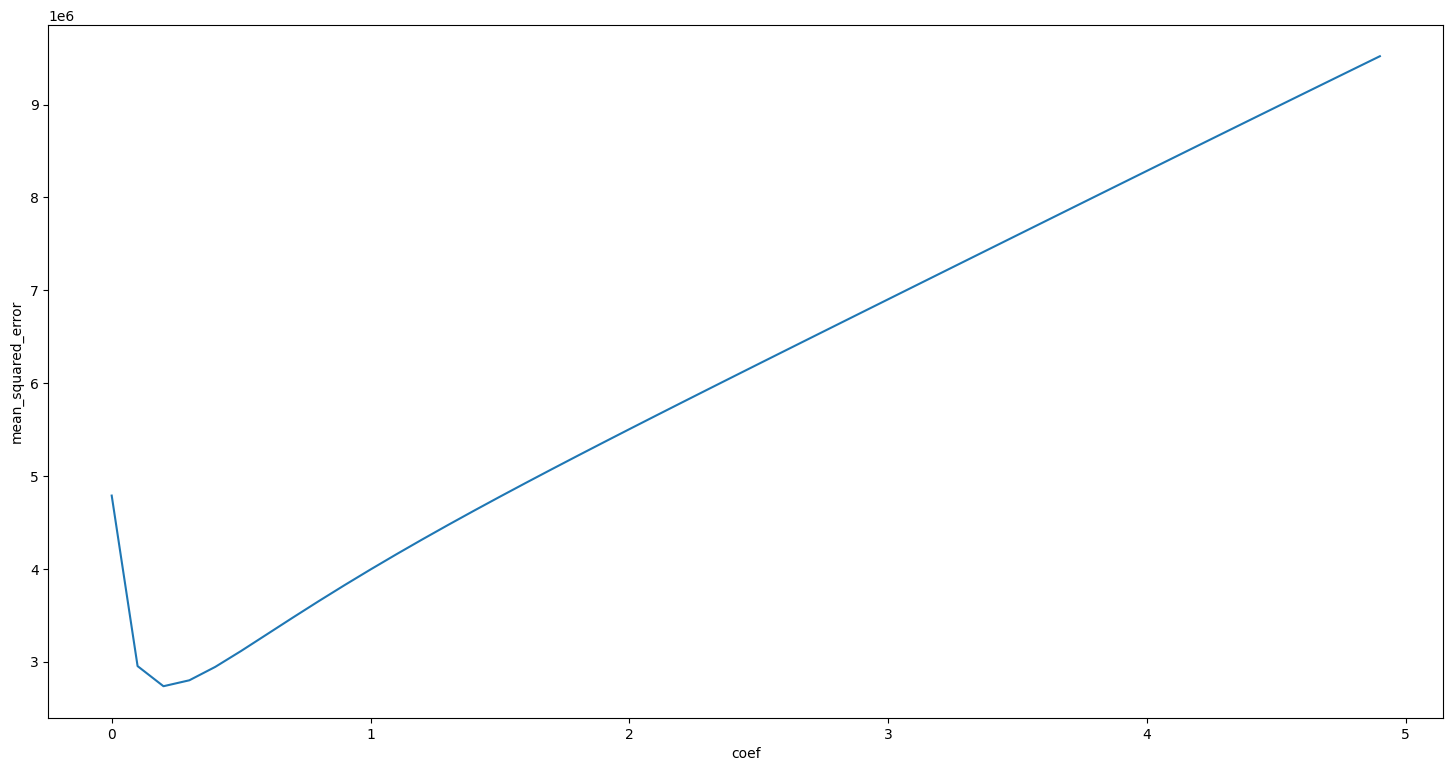

In [28]:

plt.plot(np.arange(0, 5, 0.1), [mean_squared_error(LinearRegression(MSEL2Loss(coef)).fit(
    X_train, y_train).predict(X_test), y_test) for coef in np.arange(0, 5, 0.1)])
plt.xlabel('coef')
plt.ylabel('mean_squared_error')
min_error = 100000000000000
best_coef = 0
for coef in np.arange(0, 0.5, 0.01):
    value = mean_squared_error(LinearRegression(MSEL2Loss(coef)).fit(
        X_train, y_train).predict(X_test), y_test)
    if (value < min_error):
        min_error = value
        best_coef = coef
best_coef

In [29]:
linear_regression = LinearRegression(MSELoss()).fit(X_train, y_train)
print(f'Train without regularization: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(f'Test without regularization: {mean_squared_error(linear_regression.predict(X_test), y_test)}')
linear_regression = LinearRegression(MSEL2Loss(best_coef)).fit(X_train, y_train)
print(f'Train with regularization: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(f'Test with regularization: {mean_squared_error(linear_regression.predict(X_test), y_test)}')

Train without regularization: 2018484.279010891
Test without regularization: 4787794.899591795
Train with regularization: 3097438.1100494736
Test with regularization: 2733780.7372587686


**Вывод**: Регуляризация негативно повлияла на ошибка на обучающей выборке, но улучшила результат на тестовой выборке

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [30]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float = 1000) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        result = 0
        for i in range(X.shape[0]):
            z = np.dot(X[i], w)-y[i]
            if self.eps > z and -self.eps < z:
                result += z*z/2
            else:
                result += self.eps(abs(z)-self.eps/2)
        result /= X.shape[0]
        return result

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        result = np.zeros_like(X[0])
        for i in range(X.shape[0]):
            z = (np.dot(X[i], w)-y[i])[0]
            if not (self.eps > z and -self.eps < z):
                z = self.eps*(np.sign(z))
            result += z*X[i]
        result /= X.shape[0]
        result = result.reshape((result.shape[0],1))
        return result


**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [31]:
linear_regression = LinearRegression(MSELoss()).fit(X_train, y_train)
print(f'Train without regularization: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(f'Test without regularization: {mean_squared_error(linear_regression.predict(X_test), y_test)}')
linear_regression = LinearRegression(HuberLoss()).fit(X_train, y_train)
print(f'Train with HuberLoss: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(f'Test with HuberLoss: {mean_squared_error(linear_regression.predict(X_test), y_test)}')

Train without regularization: 2018484.279010891
Test without regularization: 4787794.899591795
Train with HuberLoss: 2737298.377319624
Test with HuberLoss: 4072323.0700268075


**Вывод**: Рассматриваемая функция потерь негативно повлияла на ошибка на обучающей выборке, но улучшила результат на тестовой выборке (значение epsilon по умолчанию взято 1000).

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

In [32]:
# -- YOUR MEME HERE --

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [33]:
class SimulatedAnnealing:
    def __init__(self, lr: int, n_iterations: int) -> None:
        self.n_iterations = n_iterations
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        def error(X: np.ndarray, y: np.ndarray, w: np.ndarray):
            return mean_squared_error(np.dot(X, w), y)

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        old_w = np.zeros_like(X[0])
        for _ in range(self.n_iterations):
            new_w = old_w+lr*np.random.standard_t(3, size=old_w.shape)
            if error(X, y, new_w) < error(X, y, old_w):
                old_w = new_w
        self.w = old_w
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert hasattr(self, "w"), "Model must be fitted first"
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return np.dot(X, self.w)

In [34]:
linear_regression = SimulatedAnnealing(5, 100000).fit(X_train, y_train)
print(
    f'Train with SimulatedAnnealing: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(
    f'Test with SimulatedAnnealing: {mean_squared_error(linear_regression.predict(X_test), y_test)}')
linear_regression = LinearRegression(MSELoss()).fit(X_train, y_train)
print(
    f'Train without regularization: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(
    f'Test without regularization: {mean_squared_error(linear_regression.predict(X_test), y_test)}')
linear_regression = LinearRegression(HuberLoss()).fit(X_train, y_train)
print(
    f'Train with HuberLoss: {mean_squared_error(linear_regression.predict(X_train), y_train)}')
print(
    f'Test with HuberLoss: {mean_squared_error(linear_regression.predict(X_test), y_test)}')

Train with SimulatedAnnealing: 243491393.3348851
Test with SimulatedAnnealing: 211661602.3142914
Train without regularization: 2018484.279010891
Test without regularization: 4787794.899591795
Train with HuberLoss: 2737298.377319624
Test with HuberLoss: 4072323.0700268075


**Вывод**: На данной выборке алгоритм имитации отжига показывает себя хуже, чем остальные, но стоит отметить, что его результат очень зависит от способа генерации начальной точки, а также способа нахождения следующей.